In [1]:
###OPTIMISATION OF ALGORITHMIC TRADING STRATEGIES (ATS)
## ALGO TRADING STRATEGIES HAVE PARAMETERS OPTIMISED THROUGH COORDINATE DESCENT ON Linear REGRESSION
### DEFINED IN PROJECT_LIB4.PY IN INPUTS+SIGNAL()
## EXAMPLES: MACD(50,200), RSI(14), BOLLINGER BANDS ETC
# PROGRAM WILL OPTIMISE THE WEIGHTS BETWEEN STRATEGIES PER ASSET, AND THEN OPTIMIZE THE WEIGHTS BETWEEN ASSETS
# Most functions in project_lib4.py
# Training from 2000 to 2010, testing from 2010 to today (50% in sample, 50% out of sample) 
# portfolio of Brent futures, Sp500 futures, 10-year Treasuries futures, Copper futures, Nasdaq futures, Gold futures

#imports
import pandas as pd
import project_lib4 as p ##where all the files are
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np

##########FOR PYTHON############
#answer='Y'
#assets=[]
#lot_size = []
#print("####Entering assets for the portfolio to test and trade####")

#while answer=='Y':
#    ticker = input("Enter a Bloomberg ticker to test and trade: ")
#    assets.append(ticker)
#    answer = input("Would you like to enter another ticker? (Y/N): ")
#    lotsize = int(input("Lot size? (integer): "))
#    lot_size.append(lotsize)

#start_date = input("Enter start date of training (YYYMMDD): ")
#end_date = input("Enter end date of testing (YYYMMDD): ")
#insamplefactor = float(input("Enter percentage of training data (float): "))

#AND PUT LIBRARY INSIDE SAME PYTHON FILE
################################

###INPUTS####
aum=500000000 #Money under management
assets = ['CO1 COMDTY','SP1 INDEX','TY1 COMDTY','HG1 COMDTY', 'NQ1 INDEX', 'GC1 COMDTY']
#Brent futures, Sp500 futures, 10-year Treasuries futures, Copper futures, Nasdaq futures, Gold futures
lot_size=[1000,250,1000,250,20,100] #1 point move generates that amount in USD (per asset)
start_date='20000101'
end_date='20200807'
#Insample: 50%, out of sample 50% (it can be changed in project_lib2.py in my_vars())


########

 
# %% build and backtest all

reload(p) 

def run(asset,start_date,end_date):
    #load Bloomberg data for the asset between start_date and end_date
    df = p.bbload(asset,start_date,end_date)

    # create features and signals
    df = p.feature(df,start_date,end_date)
    s  = p.signal(df)

    #backtest and optimize the x vector. All results in p.F
    p.F['optTarget'] = 'sharpe'
    
    p.backtest() # run optimization per asset and backtesting (optimize between ATS for each asset)
    p.plotresult() #plotting

    
#%% Run each asset separately and store the PNL for each. Weights are optimized between ATS for each asset   

PNL = pd.DataFrame()
POS = pd.DataFrame()
dPrices = pd.DataFrame()

for i in range( len(assets) ):
    asset = assets[i]
    print('***************** '+ asset)
    run(asset,start_date,end_date)     
    name = p.F['name'] #name of asset
    PNL[name] = p.F['pnl'].copy() # daily return per asset (p.F is a dataframe that gets written over for each asset)
    POS[name] = p.F['netlev'].copy() #daily net delta per asset (before asset portfolio optimization) 
    dPrices[name] = p.F['d']['close'].copy() #daily price per asset
#PNL
#POS

***************** CO1 COMDTY
** Minimize: Target:sharpe
optimized X:
[-1.          0.1458406   0.79076119  0.0373288   1.         -1.
  0.14285714]
Max Leverage:
2.0


C:\Users\pandurand\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

***************** SP1 INDEX
** Minimize: Target:sharpe
optimized X:
[-0.68472764 -0.0258686   1.         -0.1586459   0.23256455  0.40152534
  0.14285714]
Max Leverage:
2.0


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

***************** TY1 COMDTY
** Minimize: Target:sharpe
optimized X:
[-0.11136146 -0.31495605 -0.00894742  0.17987907  1.          0.50912697
  0.39602079]
Max Leverage:
4.0


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

***************** HG1 COMDTY
** Minimize: Target:sharpe
optimized X:
[ 1.         -1.          1.          0.3602998   0.16889235 -1.
  0.14285714]
Max Leverage:
2.0


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

***************** NQ1 INDEX
** Minimize: Target:sharpe
optimized X:
[ 0.23397627 -0.0482954   0.00312031  0.01211881 -0.00965221  1.
  0.14285714]
Max Leverage:
1.3159287107236017


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

***************** GC1 COMDTY
** Minimize: Target:sharpe
optimized X:
[-1.          0.14200939  1.          1.          0.93875995 -0.00986603
  0.14285714]
Max Leverage:
2.0


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

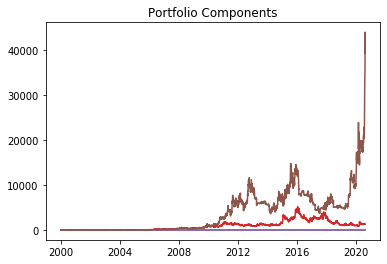

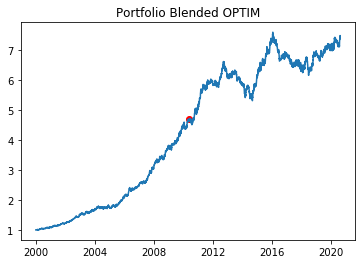

In [2]:
# %% optimize portfolio of assets (2nd optimization)
p.PF = PNL
xb = p.pfopt(PNL) #optimize between weights of assets (and plot PNL of each)

PNLw = PNL*xb  # total weighted pnl

pfcumpnl = PNLw.sum(axis=1).cumsum().apply(np.exp) #cumulative returns+1, ie the path of $1 over time

plt.plot(PNL.cumsum().apply(np.exp)) #plotting each portfolio component before weights between them
plt.title('Portfolio Components')
plt.show()

v = p.myvars() #loading global constraints variables
n = int(len(pfcumpnl) * v['insamplefactor'])  #point where out of sample starts
plt.plot(pfcumpnl) #plotting results of $1 invested at start in global portfolio
plt.title('Portfolio Blended OPTIM')
plt.scatter(pfcumpnl.index[n],pfcumpnl[n],color='r') # Red point is where Testing data starts
plt.show()
 

In [4]:
v=p.myvars()
path=PNLw.sum(axis=1)
n=len(path)
m=int(n*v['insamplefactor'])
print('Sharpe in sample: ', round(p.sharpe(path[0:m]),2))
print('Sharpe out of sample: ', round(p.sharpe(path[m+1:n]),2))
print('Volatility in sample: ', round(np.std(path[0:m])*np.sqrt(252),3))
print('Volatility out of sample: ', round(np.std(path[m+1:n])*np.sqrt(252),3))
tretIS=round(pfcumpnl[m]/pfcumpnl[0]-1,2)
print('Total return in sample: ', tretIS)
tretOS=round(pfcumpnl[n-1]/pfcumpnl[m]-1,2)
print('Total return out of sample: ', tretOS)
daysIS=m
daysOS=n-m
yearsIS=daysIS/252
yearsOS=daysOS/252
aretIS=round((1+tretIS)**(1/yearsIS)-1,4)
aretOS=round((1+tretOS)**(1/yearsOS)-1,4)
print('Annualized return in sample: ', aretIS)
print('Annualized return out of sample: ', aretOS)
print('years in sample: ', round(yearsIS,2))
print('years out of sample: ', round(yearsOS,2))

Sharpe in sample:  2.13
Sharpe out of sample:  0.57
Volatility in sample:  0.074
Volatility out of sample:  0.079
Total return in sample:  3.7
Total return out of sample:  0.58
Annualized return in sample:  0.1591
Annualized return out of sample:  0.0446
years in sample:  10.48
years out of sample:  10.48


|         | Main | Gridsearch | LR opt |
|---------|------|------------|--------|
|Sharpe IS| 1.98 | 3.22       |  2.13  |
|Sharpe OS| 0.81 | 0.32       |  0.57  |

This optimisation is better than the Gridsearch on OS, but worse on IS
Sharpe IS is slightly better than without parameter optimisation but Sharpe Os is worse.
## Conclusion:
Parameter optimisation does not bring better results out of sample, as parameter optimisation overfits to training data. 

Now we want to output trades to do at the close today, assuming we run the program a few minutes before the close.
It also outputs charts of historical trades per contract, and at the end the historical net leverage overall

Trades for CO1 : 6.0
Trades for SP1 : 2.0
Trades for TY1 : 169.0
Trades for HG1 : 205.0
Trades for NQ1 : 9.0
Trades for GC1 : 0.0


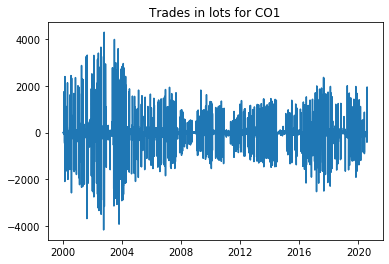

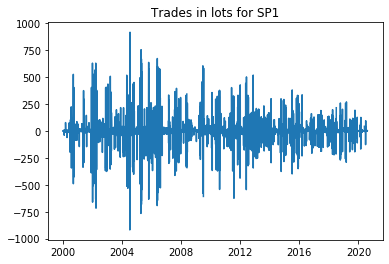

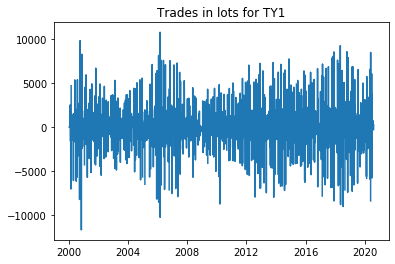

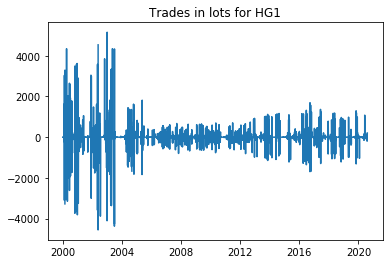

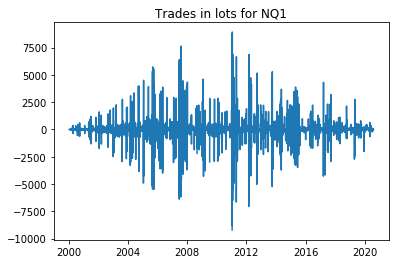

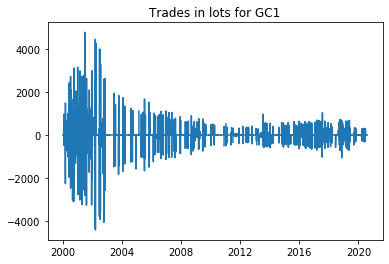

In [5]:
#Printing trades to make today. Bloomberg is loading the latest datapoint for each asset today. 
#It should be run a few minutes before the close
trades=(POS-POS.shift(1))*xb*aum #trade value in USD per day
lotvalue=dPrices*lot_size #USD value of a lot for each contract (asset)
orders=pd.DataFrame(round(trades/lotvalue)) #Dadaframe showing daily lot orders per contract

for asset in orders.columns:
    print("Trades for "+asset+" :", orders[asset].tail(1)[0]) #printing the trades to make now
    
#Showing historical trades in lots per contract for information
for asset in orders.columns:
    plt.plot(orders[asset])
    plt.title("Trades in lots for "+asset)
    plt.show()

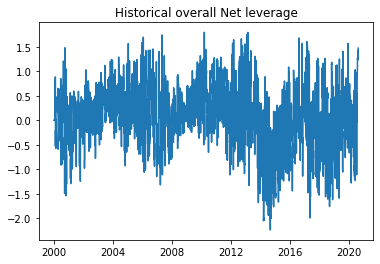

In [6]:
plt.plot((POS*xb).sum(axis=1))
plt.title("Historical overall Net leverage")
plt.show()